# Reanalysing data from the COVID-19 multiomics project

This notebook is provided as a similar case study for our pipeline. [It is conceptually similar to our previous integrative analysis of proteome and translatome data, but contains a larger quantity of omics data and samples](https://gitlab.com/tyagilab/sars-cov-2/-/blob/master/README.md).

Full details of the original study can be found in the original publication: [https://dx.doi.org/10.1101%2F2020.07.17.20156513](https://dx.doi.org/10.1101%2F2020.07.17.20156513)

[Authors provided a sql database with accession number `MSV000085703`](ftp://massive.ucsd.edu/MSV000085703/other/Covid-19%20Study%20DB.sqlite) from which multiomics data measurements were extracted.

## Summary of the study

*This information is taken from the original study by [Overmyer et al 2020](https://dx.doi.org/10.1101%2F2020.07.17.20156513)*

The authors intended to investigate (a) biological insight into the host's response to SARS-CoV-2, and (b) pathways influencing its severity. Authors integrated molecule measurements with clinical attributes and identified features associated with (1) COVID-19 status and (2) HFD-45 (hospital free days, this is a composite metric).

The authors performed multiple experiments to obtain their results (summarised below). We focus on the specific experiment of `covid severity` to illustrate the usage of our pipeline on this case study.

### Covid state

To identify differentially abundant molecules, authors performed **ANOVA and log-likelihood ratio tests** to discover: 
- 2,537 leukocyte transcripts, 
- 146 plasma proteins, 
- 168 plasma lipids,
- 13 plasma metabolites
associated with COVID-19 status (Table S1). 

To discover enriched biological processes associated with the differing biomolecules, the authors used **GO and molecular class enrichment analysis** (Tables S2A and S2B). The authors showed that these included: 
- mitotic cell cycle, 
- phagocytosis recognition, 
- positive recognition of B cell activation, 
- complement activation (classical pathway), 
- innate immune response.

### Covid severity

To discover biomolecules associated with severity, authors used **univariate regression** of HFD-45 against abundance of each biomolecule. Authors accounted for sex and age and found disease associated molcules (Table S1):
- 6,202 transcripts, 
- 189 plasma proteins, 
- 218 plasma lipids,  
- 35 plasma small molecules

To further refine these authors performed **multivariate linear regression** on HFD-45 using the elastic net penalty (Zou and Hastie, 2005) as predictive features for HFD-45 (Table S1):
- 497 transcripts, 
- 382 proteins, 
- 140 lipids, 
- 60 metabolites 

### Combined information

To generate a list of 219 features that were most significantly associated with COVID-19 status and severity (Figure 2C; Table S1), the authors combined: 
1. significance with COVID-19 status, 
2. significance with HFD-45, 
3. elastic net feature selection

In [1]:
import os
import matplotlib.pyplot as plt
import pandas as pd
from functools import reduce
from scipy import stats
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests
%matplotlib inline

Tables in sqlite database:

```
biomolecules                   
deidentified_patient_metadata  
lipidomics_measurements        proteomics_measurements
lipidomics_runs                proteomics_runs
metabolomics_measurements      pvalues
metabolomics_runs              rawfiles
metadata                       transcriptomics_measurements
omes                           transcriptomics_runs
```

`.csv` files were extracted from the publicly accessible `sqlite` database. The following set of commands were repeated for each of the tables listed above.

```
.file 'Covid-19 Study DB.sqlite'
.header on
.mode csv

.output ${TABLE}.csv
select * from ${TABLE};
```

`md5` sums are shown below for reproducibility:

In [2]:
!for i in $(find . -name "*csv" | sort); do md5 $i; done

MD5 (./biomolecules.csv) = fe0f68f97ffdfef77c4a295cb57447a8
MD5 (./deidentified_patient_metadata.csv) = 14501da2f118dfc74cb26cfb91c6b8b4
MD5 (./lipidomics_measurements.csv) = c480651f7e570d37358bfe8ce5b76943
MD5 (./lipidomics_runs.csv) = 9816c081378a56b37c62bc7c3f1026d9
MD5 (./metabolomics_measurements.csv) = 16b8e7c19686816f9034f986835f0491
MD5 (./metabolomics_runs.csv) = a5301afb3f24bb43abdd044814d9e5a3
MD5 (./metadata.csv) = ffae3794ec2c21ec4513a6ca4028cbb1
MD5 (./omes.csv) = cdcb74634594b9991468c7ff5302e4c7
MD5 (./proteomics_measurements.csv) = 7cf5f63e2c30b692610ca1075446a159
MD5 (./proteomics_runs.csv) = 0f6e02c4277c5be3d05da71ef338d7e7
MD5 (./pvalues.csv) = db183bacd39ba6e15a1064890e554c55
MD5 (./rawfiles.csv) = 4aca8bd70db90e9a2fbe4d997188e057
MD5 (./transcriptomics_measurements.csv) = 005871ef93964adfecce2db5cce98a5c
MD5 (./transcriptomics_runs.csv) = e79131cf120d80b0175f0732ccfdf4a9


In [3]:
files = [x for x in os.listdir() if x.endswith("csv")]
data = [pd.read_csv(x, sep=",") for x in files]
data = dict(zip(files, data))
data.keys()

dict_keys(['proteomics_runs.csv', 'rawfiles.csv', 'proteomics_measurements.csv', 'lipidomics_measurements.csv', 'deidentified_patient_metadata.csv', 'transcriptomics_measurements.csv', 'transcriptomics_runs.csv', 'pvalues.csv', 'lipidomics_runs.csv', 'metabolomics_measurements.csv', 'metadata.csv', 'metabolomics_runs.csv', 'omes.csv', 'biomolecules.csv'])

Data is spread across individual `sql` tables. We remap the numerical codes to biologically meaningful identifiers. Database schema is available in Supp Fig S3 of the original manuscript.

In [4]:
def biomolecules_to_omes(data):
    gene = pd.DataFrame([[5, "Gene"]], columns=["omics_id", "omics_name"])
    omes = pd.concat([data["omes.csv"], gene])
    biomolecules = data["biomolecules.csv"]
    biomolecules = biomolecules.merge(omes, left_on="omics_id", right_on="omics_id", how="outer")
    return biomolecules

biomolecules = biomolecules_to_omes(data)
keep = biomolecules[biomolecules["keep"] == "1"]["biomolecule_id"].tolist()
biomolecules

,biomolecule_id,standardized_name,omics_id,keep,omics_name
0,1,unknown RT 4.081766,3,1,Discovery Metabolomics
1,2,unknown RT 4.148561,3,1,Discovery Metabolomics
2,3,unknown RT 5.261918,3,1,Discovery Metabolomics
3,4,unknown RT 5.349937,3,1,Discovery Metabolomics
4,5,unknown RT 5.462593,3,1,Discovery Metabolomics
...,...,...,...,...,...
27738,27795,ZYG11A,5,1,Gene
27739,27796,ZYG11B,5,1,Gene
27740,27797,ZYX,5,1,Gene
27741,27798,ZZEF1,5,1,Gene


## Selection of Outcome Measure

The authors constructed a composite variable `HFD-45` (hospital-free days at day 45). This assigns zero value to patients requiring admission longer than 45 days or who die during the admission, and progressively more free days depending on the hospitalization length. A lower value indicates higher severity.

The variable is intended to:

1. be able to combine severity of disease with mortality in one single metric; 
2. be amenable to both ICU and medical floor populations; 
3. use a timeframe that accounts for the fact that COVID-19 patients with respiratory failure require longer hospitalizations compared with non-COVID-19 individuals (Wang et al., 2020a, 2020b); 
4. consider that COVID-19 causes a linear disease’s deterioration pattern that transition from mild respiratory compromise to respiratory failure, followed by respiratory distress requiring mechanical ventilatory support and eventually death.

## Examining the raw data

In [5]:
patient_metadata = data["deidentified_patient_metadata.csv"]
raw_files = data["rawfiles.csv"]
patient_files = raw_files.merge(patient_metadata, left_on="sample_id", right_on="sample_id", how="left")
patient_files.rename(columns={"keep": "keep_patient"}, inplace=True)
patient_files

,rawfile_id,timestamp,rawfile_name,sample_id,run_type,keep_patient,batch,ome_id,Sample_label,Albany_sampleID,...,Vent_free_days,DM,Hospital_free_days_45,Ferritin_NG/ML,CRP_MG/L,DDIMER_mg/L_FEU,Procalcitonin_NG/ML,Lactate_MMol/L,Fibrinogen,SOFA
0,1,2.020043e+13,20200427_KAO_Control_1,-1,Control,1,1,2,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2.020043e+13,20200427_KAO_Control_2,-1,Control,1,1,2,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2.020043e+13,20200427_KAO_Control_3,-1,Control,1,1,2,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2.020043e+13,20200427_KAO_Control_4,-1,Control,1,1,2,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2.020043e+13,20200427_KAO_COVID_11,11,Sample,1,1,2,COVID_11,C11,...,28.0,1.0,37.0,401.0,64.1,NaN,0.21,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
890,891,-1.000000e+00,NC021,124,Sample,1,1,5,NONCOVID_21,NC21,...,28.0,1.0,36.0,106.0,NaN,1.46,NaN,0.73,377.0,NaN
891,892,-1.000000e+00,NC022,125,Sample,1,1,5,NONCOVID_22,NC22,...,28.0,0.0,43.0,NaN,26.1,NaN,0.05,NaN,NaN,1.0
892,893,-1.000000e+00,NC023,126,Sample,1,1,5,NONCOVID_23,NC23,...,28.0,0.0,40.0,85.0,41.0,1.87,0.73,1.99,635.0,NaN
893,894,-1.000000e+00,NC024,127,Sample,1,1,5,NONCOVID_24,NC24,...,28.0,0.0,43.0,NaN,NaN,0.19,NaN,0.87,NaN,NaN


The raw data is assigned to individual categories based on their omics category (lipidome, metabolome, proteome, transcriptome).

In [6]:
def biomolecules_to_data(biomolecules, data):
    # biomolecules = biomolecules[biomolecules["keep"] == "1"]
    return data.merge(biomolecules, left_on="biomolecule_id", right_on="biomolecule_id", how="left")

def measurements_to_runs(data, runs):
    return data.merge(runs, left_on="replicate_id", right_on="replicate_id", how="left")

def runs_to_patient(runs, patient):
    return runs.merge(patient, left_on="rawfile_id", right_on="rawfile_id", how="left")

omics = {"L": data['lipidomics_measurements.csv'],
         "M": data['metabolomics_measurements.csv'],
         "P": data['proteomics_measurements.csv'],
         "T": data['transcriptomics_measurements.csv'],}

runs = {"L": data['lipidomics_runs.csv'],
        "M": data['metabolomics_runs.csv'],
        "P": data['proteomics_runs.csv'],
        "T": data['transcriptomics_runs.csv'],}

omics = [measurements_to_runs(omics[i], runs[i]) for i in omics.keys()]
omics = dict(zip(runs.keys(), omics))
omics = [runs_to_patient(omics[i], patient_files) for i in omics.keys()]
omics = dict(zip(runs.keys(), omics))
data_omics = [biomolecules_to_data(biomolecules, omics[i]) for i in omics.keys()]
patient_status = "Albany_sampleID" # unique_identifier

## Lipidomics

### Experiment notes

"The LC–MS data were processed using Compound Discoverer 2.1 (Thermo Scientific) and LipiDex (Hutchins et al., 2018) (v. 1.1.0). All peaks between 1 min and 45 min retention time and 100 Da to 5000 Da MS1 precursor mass were grouped into distinct chromatographic profiles (i.e., compound groups) and aligned using a 10-ppm mass and 0.3 min retention time tolerance. Profiles not reaching a minimum peak intensity of 5x10ˆ5, a maximum peak-width of 0.75, a signal-to-noise (S/N) ratio of 3, and a 3-fold intensity increase over blanks were excluded from further processing. MS/MS spectra were searched against an in-silico generated lipid spectral library containing 35,000 unique molecular compositions representing 48 distinct lipid classes (LipiDex library “LipiDex_HCD_Formic”, with a full range of acyl-chains included). Spectral matches with a dot product score greater than 500 and a reverse dot product score greater than 700 were retained for further analysis, with a minimum 75% spectral purity for designating fatty acid composition. Removed from the data set were adducts, class IDs greater than 3.5 median absolute retention time deviation (M.A.D. RT) of each other, and features found in less than 3 files. Data were additionally searched with Compound Discoverer 3.1 with the discovery metabolomics nodes for additional spectral matching to mzCloud and mzVault libraries but retaining the feature group and peak picking settings as detailed for the Compound Discoverer 2.1 analysis." - [Overmyer et al 2020](https://dx.doi.org/10.1101%2F2020.07.17.20156513)

### Data notes

Data is a matrix of continuous values. Column names correspond to lipid names and row names correspond to sample identifiers. Lipids with no known annotation are also recorded and assigned a unique identifier based on their mass and charge.

In [7]:
l = data_omics[0][["unique_identifier", "standardized_name", "normalized_abundance", "keep"]]
l = l[l["keep"] == "1"]
l.drop("keep", axis=1, inplace=True)
l = l.pivot(index="unique_identifier", columns="standardized_name")

# this maps the sample to patient
l_id = data_omics[0][["unique_identifier", patient_status]]
l_id.drop_duplicates(inplace=True)
l_id.set_index("unique_identifier", inplace=True)

l = l.merge(l_id, left_index=True, right_index=True, how="left")
l.reset_index(inplace=True)
l.set_index(["unique_identifier", patient_status], inplace=True)
l.sort_index(level=patient_status, inplace=True)

# remove null and assign sample groups
l_class = l.reset_index()
l_class.dropna(inplace=True)

l_class["covid_state"] = l_class[patient_status]
l_class["covid_state"].replace(regex=r'^C.*', value='Covid', inplace=True)
l_class["covid_state"].replace(regex=r'^NC.*', value='NonCovid', inplace=True)
l_map = l_class[["unique_identifier", patient_status, "covid_state"]]
# l_map.to_csv("lipidomics_class.tsv", sep="\t", index=False)

l_data = l_class.drop([patient_status, "covid_state"], axis=1)
l_data.set_index("unique_identifier", inplace=True)
l_data.columns = [y for x, y in l_data.columns]
# l_data.to_csv("lipidomics_data.tsv", sep="\t")
l_data

<ipython-input-7-e734fdf2417e>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  l_id.drop_duplicates(inplace=True)
/Users/tche0054/miniconda3/envs/mixomics/lib/python3.8/site-packages/pandas/core/reshape/merge.py:648: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


,AC 10:0_RT_6.936,AC 12:0_RT_7.955,AC 13:0_RT_8.306,AC 14:0_RT_9.398,AC 14:1_RT_8.361,AC 14:1_RT_8.51,AC 16:0_RT_10.888,AC 16:0_RT_11.031,AC 16:1_RT_9.841,AC 16:1_RT_9.93,...,Unknown_mz_994.78595_+_RT_29.923,Unknown_mz_996.79724_+_RT_29.871,Unknown_mz_996.80017_+_RT_29.46,Unknown_mz_997.72388_+_RT_29.181,Unknown_mz_998.81317_+_RT_30.512,Unknown_mz_998.81342_+_RT_29.755,Unknown_mz_998.81464_+_RT_30.995,Unknown_mz_998.9093_+_RT_32.749,Unknown_mz_998.9115_+_RT_34.028,Unknown_mz_998.91168_+_RT_33.135
unique_identifier,,,,,,,,,,,,,,,,,,,,,
20200430_KAO_COVID_1,18.137455,16.841960,12.844352,14.300304,15.468755,16.006314,16.430707,16.996782,14.918037,14.601523,...,14.076770,15.393590,17.131331,11.714399,17.445405,16.802479,14.762248,18.747651,12.646510,17.301010
20200429_KAO_COVID_10,20.481348,18.060484,15.178616,15.901777,17.327229,17.866290,17.525513,18.879430,15.666328,15.922377,...,18.136994,16.393264,17.672180,15.166807,16.250905,16.163999,15.410042,19.625555,14.049023,17.740859
20200506_KAO_COVID_100,22.325877,21.306323,14.915154,19.313421,19.789357,20.138474,18.146506,19.411699,19.116553,19.121967,...,14.457549,14.017747,17.446900,11.865441,16.076784,15.667782,14.743506,18.899278,12.504215,17.375086
20200507_KAO_COVID_101,20.561890,18.847766,14.463795,17.707147,17.832855,18.290478,17.781891,18.991900,17.348757,17.078706,...,17.480097,15.235636,17.761025,11.652572,16.010433,15.183992,17.027136,16.239054,13.930821,16.350473
20200508_KAO_COVID_102,22.285913,17.983300,14.900186,14.223309,14.349153,16.391772,14.319578,15.952894,14.829781,14.005786,...,13.240386,13.434412,12.316571,10.948120,14.668392,12.885628,14.106999,18.222428,12.496043,17.117402
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20200427_KAO_NONCOVID_5,18.841850,16.238782,12.549287,14.224545,15.288985,15.018646,15.879065,16.379486,14.981624,15.399689,...,15.595231,14.418258,16.522576,10.885204,12.634746,14.287653,16.431940,18.138928,11.806145,16.372521
20200429_KAO_NONCOVID_6,18.462152,17.197018,12.948937,15.835207,17.096651,17.129969,17.125441,18.291986,16.849149,16.861315,...,14.462080,14.523028,16.724645,12.409789,16.088752,15.651846,15.872831,17.306563,11.935541,16.785932
20200429_KAO_NONCOVID_7,19.626082,18.286611,14.593291,16.611980,18.448637,18.520732,17.289492,18.614540,18.252884,18.267099,...,15.811992,14.728570,16.893317,13.662111,15.028109,15.734229,13.552950,17.144476,11.701308,16.276223


## Metabolomics

### Experiment notes

"GC-MS raw files were processed using a software suite developed in-house that is available at https://github.com/coongroup. Following data acquisition, raw EI-GC/MS spectral data was deconvolved into chromatographic features and then grouped into features based on co-elution. Only features with at least 10 fragment ions and present in 33% of samples were kept. Feature groups from samples and background were compared, and only feature groups greater than 3-fold higher than background were retained. Compound identifications for the metabolites analyzed were assigned by comparing deconvolved high-resolution spectra against unit-resolution reference spectra present in the NIST 12 MS/EI library as well as to authentic standards run in-house. To calculate spectral similarity between experimental and reference spectra, a weighted dot product calculation was used. Metabolites lacking a confident identification were classified as “Unknown metabolites” and appended a unique identifier based on retention time. Peak heights of specified quant m/z were used to represent feature (metabolite) abundance. The data set was also processed through, where we applied a robust linear regression approach, rlm() function (Marazzi et al., 1993), non- log2 transformed intensity values versus run order, to normalize for run order effects on signal. AEX-LC-MS/MS: raw files were processed using Xcalibur Qual Browser (v4.0.27.10, Thermo Scientific) with results exported and further processed using Microsoft Excel 2010. The prepared standard solution was used to locate appropriate peaks for peak area analysis." - [Overmyer et al 2020](https://dx.doi.org/10.1101%2F2020.07.17.20156513)

### Data notes

Data is a matrix of continuous values. Column names correspond to metabolite names and row names correspond to sample identifiers. Metabolites with no known annotation are also recorded and assigned a unique identifier based on their mass and charge. There are two subsets of metabolites - discovery and targeted. These were originally split into two sets for preliminary investigation but are later recombined before entering the pipeline.

In [8]:
m = data_omics[1][["unique_identifier", "standardized_name", "normalized_abundance", "keep", "omics_id"]]
m = m[m["keep"] == "1"]
m.drop("keep", axis=1, inplace=True)

m_d = m[m["omics_id"] == 3]
m_d.drop("omics_id", axis=1, inplace=True)

m_t = m[m["omics_id"] == 4]
m_t.drop("omics_id", axis=1, inplace=True)

m_d = m_d.pivot(index="unique_identifier", columns="standardized_name")
m_d.columns = [x[1] for x in m_d.columns]

# this maps the sample to patient
m_id = data_omics[1][["unique_identifier", patient_status]]
m_id.drop_duplicates(inplace=True)
m_id.set_index("unique_identifier", inplace=True)

m_d = m_d.merge(m_id, left_index=True, right_index=True, how="left")
m_d.reset_index(inplace=True)
m_d.set_index(["unique_identifier", patient_status], inplace=True)
m_d.sort_index(level=patient_status, inplace=True)

# remove null and assign sample groups
m_d_class = m_d.reset_index()
m_d_class.dropna(inplace=True)

m_d_class["covid_state"] = m_d_class[patient_status]
m_d_class["covid_state"].replace(regex=r'^C.*', value='Covid', inplace=True)
m_d_class["covid_state"].replace(regex=r'^NC.*', value='NonCovid', inplace=True)

m_d_data = m_d_class.drop([patient_status, "covid_state"], axis=1)
m_d_data.set_index("unique_identifier", inplace=True)
keep = ~m_d_data.eq(m_d_data.iloc[:, 0], axis=0).all(1)
m_d_data = m_d_data[keep]
# m_d_data.to_csv("metabolomicsdiscovery_data.tsv", sep="\t")

m_d_map = m_d_class[["unique_identifier", patient_status, "covid_state"]]
m_d_map.set_index("unique_identifier", inplace=True)
m_d_map = m_d_map[keep].reset_index()
# m_d_map.to_csv("metabolomicsdiscovery_class.tsv", sep="\t", index=False)
m_d_data

/Users/tche0054/miniconda3/envs/mixomics/lib/python3.8/site-packages/pandas/core/frame.py:4305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
/Users/tche0054/miniconda3/envs/mixomics/lib/python3.8/site-packages/pandas/core/frame.py:4305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
<ipython-input-8-4d9ee4ad5520>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_id.drop_duplicates(inplace=Tru

,"1,2-Propanediol, 2TMS derivative RT5.872253","2,3-Dihydroxybutanoic acid, tris(trimethylsilyl)- RT10.455827","2-Hydroxybutyric acid, 2TMS derivative RT7.639387",2-Ketoisocaproic acid mo-tms RT8.802217,"3-Hydroxybutyric acid, 2TMS derivative RT8.103591",3-hydroxyisovaleric acid 2TMS RT8.767878,"Aspartic acid, 3TMS derivative RT11.991212",C4H9NO2 RT8.262165_2-Aminobutyric acid 2TMS,Cholesterol derivative RT25.501888,"Creatinine, 3TMS Derivative RT12.941566",...,unknown RT 4.081766,unknown RT 4.148561,unknown RT 5.261918,unknown RT 5.349937,unknown RT 5.462593,unknown RT 7.034156,unknown RT 7.600111,unknown RT 7.826556,unknown RT 9.376246,unknown RT 9.514184
unique_identifier,,,,,,,,,,,,,,,,,,,,,
20200430_BP_COVID_1,22.525987,13.898984,22.089462,18.241204,21.557699,18.591465,20.726050,21.632363,17.874240,17.433895,...,21.309897,21.783308,22.687091,25.179914,21.630920,22.194263,17.139508,26.645522,20.097499,20.768795
20200429_BP_COVID_10,22.634601,17.851052,20.819783,16.655539,20.844457,20.316200,21.646863,20.146853,15.204200,21.190773,...,20.625906,21.873159,23.564427,27.688025,16.610075,21.886977,19.703795,25.886627,20.908232,20.654983
20200506_BP_COVID_100,22.129562,13.340284,21.038076,16.948493,22.189559,18.199033,21.432008,21.422122,17.436237,17.534745,...,20.662917,22.549653,22.840298,26.082512,20.761355,22.096221,18.075471,26.390193,20.267772,20.683572
20200507_BP_COVID_101,21.942203,17.441368,22.640710,17.050310,21.761105,17.589723,17.118803,21.067104,16.700752,18.609733,...,22.360212,21.846840,23.050276,26.990202,18.928471,22.028725,18.537347,27.219894,20.758905,21.466273
20200508_BP_COVID_102,21.875789,17.880837,22.706349,17.796130,20.446872,17.923685,18.469684,21.165818,16.414562,20.740700,...,21.813873,21.989365,24.234489,28.192456,16.838486,21.994941,20.686045,26.081353,20.743060,21.683657
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20200427_BP_NONCOVID_5_25split,21.915568,16.933270,21.654459,18.415829,20.497900,16.537212,16.361980,21.511131,16.589895,16.651303,...,22.949098,22.042485,23.800844,26.241050,18.603429,21.973979,19.925201,26.156117,22.254595,20.787593
20200429_BP_NONCOVID_6,21.053214,15.214941,21.659314,16.905788,25.120765,14.777642,20.290282,20.732187,15.766200,17.739944,...,20.437214,21.286885,22.997147,25.645325,19.348735,20.441047,18.126806,26.607854,20.291949,22.684575
20200429_BP_NONCOVID_7,22.185698,18.270518,22.467372,18.889117,26.256067,18.002887,20.886304,20.706666,20.165667,20.924139,...,21.355643,21.932206,23.535396,26.924688,18.796418,21.690482,18.910923,26.781983,20.975904,21.370005


In [9]:
m_t = m_t.pivot(index="unique_identifier", columns="standardized_name")
m_t.columns = [x[1] for x in m_t.columns]

m_t = m_t.merge(m_id, left_index=True, right_index=True, how="left")
m_t.reset_index(inplace=True)
m_t.set_index(["unique_identifier", patient_status], inplace=True)
m_t.sort_index(level=patient_status, inplace=True)

# remove null and assign sample groups
m_t_class = m_t.reset_index()
m_t_class.dropna(inplace=True)

m_t_class["covid_state"] = m_t_class[patient_status]
m_t_class["covid_state"].replace(regex=r'^C.*', value='Covid', inplace=True)
m_t_class["covid_state"].replace(regex=r'^NC.*', value='NonCovid', inplace=True)
m_t_map = m_t_class[["unique_identifier", patient_status, "covid_state"]]
# m_t_map.to_csv("metabolomicstargeted_class.tsv", sep="\t", index=False)

m_t_data = m_t_class.drop([patient_status, "covid_state"], axis=1)
m_t_data.set_index("unique_identifier", inplace=True)
# m_t_data.to_csv("metabolomicstargeted_data.tsv", sep="\t")
m_t_data

,"2,3-diP-glyceric Acid Total","2,3-dihydroxyisovaleric Acid",2-hydroxy-3-methylbutryic acid,2-methylcitric Acid,2P Glyceric and 3P Glyceric Acids,3-Deoxy-2-keto-6P-gluconic Acid,6P Gluconic Acid,ADP Total,AMP Total,ATP Total,...,Isocitric Acid,Malic Acid,Mannose 6P,Mevalonic acid,Phosphoenolpyruvic Acid,Pyruvic and Oxaloacetic Acids,Sedoheptulose 7P,Succinic Acid Total,Trans-Aconitic Acid,Xylonic Acid Total
unique_identifier,,,,,,,,,,,,,,,,,,,,,
20200430_Batch4_COVID-1,15.929258,13.371777,20.310080,16.010178,16.153631,9.753217,11.338736,16.638210,14.887030,15.167418,...,20.145693,18.943064,13.412041,12.775199,12.681678,17.804988,12.593391,20.924337,13.371777,16.599506
20200429_Batch3_COVID-10,14.709945,13.277578,18.860602,17.937328,17.441518,5.240314,14.198445,18.481484,16.470405,16.872675,...,20.194603,18.795507,14.302068,14.489346,13.666224,18.194603,13.833681,20.535640,14.901244,20.107891
20200506_Batch5_COVID-100,14.431759,12.335949,19.351647,15.444756,16.680030,9.262095,12.845490,18.125656,16.773139,16.608197,...,20.680030,18.943064,13.157978,12.519145,12.874597,18.047933,13.813781,20.506881,14.135709,17.031873
20200507_Batch6_COVID-101,16.747144,12.741888,20.654035,15.823765,17.296701,9.000000,12.225810,18.740571,17.314512,17.125656,...,21.502032,19.766684,13.813781,13.538674,12.655083,17.965784,12.398744,20.909764,14.483060,18.255803
20200508_Batch7_COVID-102,14.330357,13.813781,18.769915,16.908299,15.151651,8.247928,8.611025,15.421933,14.221285,14.425216,...,21.145693,19.886137,12.741888,15.225057,11.817783,19.323336,11.063395,19.829970,15.780847,19.915611
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20200427_Batch1_NON-COVID-5,16.666224,11.222795,20.253497,14.726005,17.241909,8.957102,12.228819,18.528027,17.232571,16.785963,...,20.857568,19.499114,14.649481,13.049849,13.204571,18.251187,14.001408,20.645264,13.699139,16.931569
20200429_Batch3_NON-COVID-6,16.747144,12.857203,19.416995,16.580494,17.375175,9.330917,12.659550,18.218450,16.693705,16.506494,...,21.126916,19.586004,14.833681,13.773139,13.741888,18.848427,13.574594,21.082128,14.470405,18.199404
20200429_Batch3_NON-COVID-7,15.457637,11.234817,19.208958,14.344296,16.666224,10.310613,12.036174,18.278667,16.515761,16.447987,...,19.945924,20.042600,13.574594,12.878434,12.849405,19.248873,13.257093,20.880169,13.425216,16.319813


## Proteomics

### Experiment notes

"Shotgun proteomics raw files were searched using MaxQuant quantitative software package (Cox et al., 2014) (version 1.6.10.43) against UniProt Homo Sapiens database (downloaded on 6.18.2019), containing protein isoforms and computationally predicted proteins. If not specified, default MaxQuant settings were used. LFQ quantification was performed using LFQ minimum ratio count of 1 and no MS/MS requirement for LFQ comparisons. iBAQ quantitation and “match between runs” were enabled with default settings. ITMS MS/MS tolerance was set to 0.35 Da. Lists of quantified protein groups were filtered to remove reverse identifications, potential contaminants, and proteins identified only by a modification site. LFQ abundance values were log2 transformed. Missing quantitative values were imputed by randomly drawing values from the left tail of the normal distribution of all measured protein abundance values (Tyanova et al., 2016). Protein groups that contained more than 50% missing values were removed from final analyses. Relative standard deviations (RSDs) for each protein group quantified across all seven technical replicates of healthy plasma controls were calculated, and proteins with RSD greater than 30% were removed from final analyses. PRM: identification and quantification of targeted peptides for PRM analysis were performed using Skyline open access software package (version 20.1). 4-5 most intense and specific transitions were used to quantify peptide abundances, and area-under-the-curve measurements for each peptide were exported for further analysis." - [Overmyer et al 2020](https://dx.doi.org/10.1101%2F2020.07.17.20156513)

### Data notes

Data is a matrix of continuous values. Column names correspond to protein names and row names correspond to sample identifiers.

In [10]:
p = data_omics[2][["unique_identifier", "standardized_name", "normalized_abundance", "keep"]]
p = p[p["keep"] == "1"]
p.drop("keep", axis=1, inplace=True)
p = p.pivot(index="unique_identifier", columns="standardized_name")
p.columns = [x[1] for x in p.columns]

# this maps the sample to patient
p_id = data_omics[2][["unique_identifier", patient_status]]
p_id.drop_duplicates(inplace=True)
p_id.set_index("unique_identifier", inplace=True)

p = p.merge(p_id, left_index=True, right_index=True, how="left")
p.reset_index(inplace=True)
p.set_index(["unique_identifier", patient_status], inplace=True)
p.sort_index(level=patient_status, inplace=True)

# remove null and assign sample groups
p_class = p.reset_index()
p_class.dropna(inplace=True)

p_class["covid_state"] = p_class[patient_status]
p_class["covid_state"].replace(regex=r'^C.*', value='Covid', inplace=True)
p_class["covid_state"].replace(regex=r'^NC.*', value='NonCovid', inplace=True)
p_map = p_class[["unique_identifier", patient_status, "covid_state"]]
# p_map.to_csv("proteomics_class.tsv", sep="\t", index=False)

p_data = p_class.drop([patient_status, "covid_state"], axis=1)
p_data.set_index("unique_identifier", inplace=True)
# p_data.to_csv("proteomics_data.tsv", sep="\t")
p_data

<ipython-input-10-0c575882c4d7>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p_id.drop_duplicates(inplace=True)


,A0A024R6I7;A0A0G2JRN3,A0A075B6H9,A0A075B6I0,A0A075B6I4;A0A1W2PQ80,A0A075B6I9,A0A075B6J1,A0A075B6J9,A0A075B6K4,A0A075B6K5,A0A075B6P5;P01615,...,Q9UHG3;Q9UHG3-2,Q9UJJ9;H0YEA7;A0A087WWA2,Q9ULV4;Q9ULV4-2;Q9ULV4-3;B4E3S0,Q9UNW1;Q9UNW1-3;Q9UNW1-2;Q9UNW1-4,Q9Y5C1,Q9Y6R7;A0A087WXI2,U3KQK0;Q99879;Q99877;Q93079;Q5QNW6;P62807;P58876;P57053;O60814;Q5QNW6-2;Q99880;Q96A08,V9GY83;P12318-2;P12318;F5GXY9;F5GX41;A0A087WXE5;H0YGT0;P31995-4;P31995-3;P31995-2;P31994-5;P31994-2;P31994-3;P31994-4;P31994;P31995,V9GYM3;P02652;V9GYE3;V9GYG9,X6R8F3;P80188;P80188-2
unique_identifier,,,,,,,,,,,,,,,,,,,,,
20200509_ES_Albany_COVID19_batch4_single-shot_1,37.995543,27.176361,28.294477,24.783368,23.926601,23.490571,25.490816,29.287382,29.505121,29.909421,...,25.746683,22.593546,22.024047,23.733969,19.755864,29.920821,25.980045,22.915739,30.157740,22.821315
20200507_ES_Albany_COVID19_batch3_single-shot_10,37.844902,29.253091,29.108465,27.163654,26.153098,23.410928,25.983049,31.884783,30.811611,30.313652,...,25.066611,18.732647,23.311190,23.365730,22.860450,29.123220,26.626866,20.549497,29.039570,24.971321
202005010_ES_Albany_COVID19_batch5_single-shot_100,37.787556,26.969061,28.103146,26.583481,25.303093,20.852103,25.527788,28.278393,29.567178,29.739326,...,25.620728,22.462663,21.858593,19.910574,20.280955,29.344964,26.127093,19.045373,29.809527,20.628008
202005011_ES_Albany_COVID19_batch6_single-shot_101,37.068980,32.415410,28.430139,26.307425,26.740082,23.796498,26.716858,30.895548,30.786904,31.184766,...,26.332807,19.186623,22.832928,22.386060,19.014014,30.864890,26.642788,19.000200,30.144673,23.200856
202005013_ES_Albany_COVID19_batch7_single-shot_102,38.004675,26.636994,28.346803,26.662073,25.585918,24.429053,26.073349,29.878007,29.607049,29.886157,...,24.403406,18.731712,20.565203,17.810879,21.886956,29.745766,25.817997,22.041598,29.663295,27.093859
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20200514_ES_Albany_NON-COVID19_batch1_single-shot_5,37.507418,27.417478,27.946370,20.876354,23.634669,23.275261,24.028083,30.347838,30.519627,29.413691,...,24.737274,21.209978,19.305794,23.388900,20.100082,30.514933,24.787259,20.727730,31.182637,23.367064
20200507_ES_Albany_NON-COVID19_batch3_single-shot_6,38.077710,28.885038,29.587350,28.359803,25.850146,25.118228,27.627354,31.012653,31.886201,31.500855,...,25.715104,22.680931,21.616073,23.731174,21.191438,30.347099,26.293109,23.689552,30.906700,19.936465
20200507_ES_Albany_NON-COVID19_batch3_single-shot_7,37.612697,28.203312,29.300686,25.932312,25.214008,24.135788,26.376219,29.235121,29.830442,31.023335,...,25.084279,23.179542,22.667221,23.781968,22.536707,30.189428,26.315152,23.156072,31.662166,25.886323


## RNA-Seq Data Processing

"All RNA transcripts were downloaded from the NCBI refseq ftp site (wget ftp://ftp.ncbi.nlm.nih.gov/refseq/H_sapiens/mRNA_Prot/∗.rna.fna.gz ). Only mRNA (accessions NM_xxxx and XM_xxxx) and rRNA (excluding 5.8S) was then extracted, and immunoglobulin transcripts were downloaded from ENSEMBL (IG_C, IG_D, IG_J and IG_V ). We created a file mapping accession numbers to gene symbols, and then used rsem-prepare-reference to build a bowtie-2 reference database. Fastq files were trimmed and filtered using a custom algorithm tailored to improve quality scores and maximize retained reads in paired-end data. RNA-Seq expression estimation was performed by RSEM v 1.3.0 (parameters: seed-length=20, no-qualities, bowtie2-k=200, bowtie2-sensitivity-level=sensitive) (Li and Dewey, 2011), with bowtie-2 (v 2.3.4.1) for the alignment step (Langmead and Salzberg, 2012), using the custom hg38 reference described above. After the collation of expression estimates, hemoglobin transcripts were removed from further analysis, and TPM values were rescaled to total 1,000,000 in each sample. Differential Expression analysis was performed using the EBSeq package (v 1.26.0) (Leng et al., 2013) in R (v 3.6.2)." - [Overmyer et al 2020](https://dx.doi.org/10.1101%2F2020.07.17.20156513)

### Data notes

Data is a matrix of continuous values. Zero values exist. Column names correspond to gene names and row names correspond to sample identifiers.

In [11]:
t = data_omics[3][["unique_identifier", "standardized_name", "normalized_abundance", "keep"]]
t = t[t["keep"] == "1"]
t.drop("keep", axis=1, inplace=True)
t = t.pivot(index="unique_identifier", columns="standardized_name")
t.columns = [x[1] for x in t.columns]

# this maps the sample to patient
t_id = data_omics[3][["unique_identifier", patient_status]]
t_id.drop_duplicates(inplace=True)
t_id.set_index("unique_identifier", inplace=True)

t = t.merge(t_id, left_index=True, right_index=True, how="left")
t.reset_index(inplace=True)
t.set_index(["unique_identifier", patient_status], inplace=True)

t.sort_index(level=patient_status, inplace=True)

# remove null and assign sample groups
t_class = t.reset_index()
t_class.dropna(inplace=True)

t_class["covid_state"] = t_class[patient_status]
t_class["covid_state"].replace(regex=r'^C.*', value='Covid', inplace=True)
t_class["covid_state"].replace(regex=r'^NC.*', value='NonCovid', inplace=True)
t_map = t_class[["unique_identifier", patient_status, "covid_state"]]
# t_map.to_csv("transcriptomics_class.tsv", sep="\t", index=False)

t_data = t_class.drop([patient_status, "covid_state"], axis=1)
t_data.set_index("unique_identifier", inplace=True)
# t_data.to_csv("transcriptomics_data.tsv", sep="\t")
t_data

<ipython-input-11-e241a1e1e4de>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  t_id.drop_duplicates(inplace=True)


,A1BG,A2M,AAAS,AACS,AAGAB,AAK1,AAMDC,AAMP,AANAT,AAR2,...,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
unique_identifier,,,,,,,,,,,,,,,,,,,,,
C001,4.5,3.7,8.7,7.4,9.8,9.8,6.5,10.3,3.0,9.3,...,6.9,6.4,6.0,6.9,9.6,1.9,9.8,13.3,11.5,9.0
C010,2.9,3.7,9.0,7.5,9.6,9.3,6.7,10.2,1.8,9.0,...,7.7,8.7,4.3,5.8,10.0,3.5,9.4,14.1,11.0,8.2
C100,4.6,3.3,9.5,7.1,10.0,9.2,7.5,10.2,3.8,9.3,...,6.3,7.3,5.0,6.4,9.8,3.5,9.2,14.3,10.0,8.0
C101,4.3,3.2,9.6,7.3,9.7,9.6,7.1,10.6,2.4,9.6,...,7.0,7.0,5.4,7.6,9.6,3.9,8.7,13.3,10.6,8.6
C102,3.3,1.0,8.4,6.2,10.0,10.3,5.9,9.0,4.1,8.6,...,7.2,6.3,5.8,6.5,9.7,3.5,9.9,14.7,11.5,8.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NC005,5.0,1.1,9.6,6.9,9.9,9.7,8.0,10.3,6.1,9.3,...,6.1,5.6,4.7,6.5,9.6,4.6,9.2,14.8,10.3,7.2
NC006,6.0,3.9,9.9,7.7,9.6,9.5,7.3,11.1,1.5,10.1,...,5.9,6.6,5.7,6.5,8.9,2.1,8.1,13.7,10.3,7.9
NC007,4.8,2.7,9.1,6.6,9.6,9.7,6.3,10.3,1.4,9.3,...,6.8,5.3,5.3,7.0,9.9,2.6,9.4,14.1,11.0,8.6


## Sample filtering

Our pipeline and underlying methods require all samples to be identical across the blocks of omics data. These steps filter out all samples which are not represented in each omics data block.

In [12]:
# our framework only ingests data with matched samples
data_clean = [l_data, m_d_data, m_t_data, p_data, t_data]
maps = [l_map, m_d_map, m_t_map, p_map, t_map]
maps = [x.set_index("Albany_sampleID") for x in maps]
common = [set(x.index.tolist()) for x in maps]
common = set.intersection(*common)
maps = [x.loc[list(common)] for x in maps]
matched = [i.loc[j["unique_identifier"]] for i, j in tuple(zip(data_clean, maps))]
[x.shape for x in matched]

[(125, 3357), (125, 111), (125, 39), (125, 517), (125, 13263)]

## Sample mapping

Unique sample identifiers are matched to their biologically relevant sample categories. Long feature names are also shortened, and mapping files containing the original names are provided for later recovery if necessary.

In [13]:
# remap identifiers to sample types
def map_common_id(metadata, data):
    metadata = pd.DataFrame(metadata.set_index("unique_identifier")["Albany_sampleID"])
    data = pd.merge(metadata, data, left_index=True, right_index=True)
    data = data.reset_index().set_index("Albany_sampleID")
    data.index.name = None
    return data.drop("unique_identifier", axis=1)

# long feature names break the pipeline
def shorten_colnames(data):
    name_long = pd.Series(data.columns, name="long")
    data.columns = [x[:24] for x in data.columns]
    name_short = pd.Series(data.columns, name="short")
    name_map = pd.concat([name_short, name_long], axis=1)
    return data, name_map

classes_clean = [l_class, m_d_class, m_t_class, p_class, t_class]
data_final = [map_common_id(x, y) for x, y in tuple(zip(classes_clean, matched))]
data_short = [shorten_colnames(x) for x in data_final]
data_map = [x[1] for x in data_short]
data_final = [x[0] for x in data_short]

In [14]:
outdata = [
    "../../data/MSV000085703/data_lipidomics.tsv" ,
    "../../data/MSV000085703/data_metabolomicsdiscovery.tsv" ,
    "../../data/MSV000085703/data_metabolomicstargeted.tsv" ,
    "../../data/MSV000085703/data_proteomics.tsv" ,
    "../../data/MSV000085703/data_transcriptomics.tsv" ,
]

outbalanced = [
    "../../data/MSV000085703/balanced/data_lipidomics.tsv" ,
    "../../data/MSV000085703/balanced/data_metabolomicsdiscovery.tsv" ,
    "../../data/MSV000085703/balanced/data_metabolomicstargeted.tsv" ,
    "../../data/MSV000085703/balanced/data_proteomics.tsv" ,
    "../../data/MSV000085703/balanced/data_transcriptomics.tsv" ,
]

outhfd45 = [
    "../../data/MSV000085703/hfd45/data_lipidomics.tsv" ,
    "../../data/MSV000085703/hfd45/data_metabolomicsdiscovery.tsv" ,
    "../../data/MSV000085703/hfd45/data_metabolomicstargeted.tsv" ,
    "../../data/MSV000085703/hfd45/data_proteomics.tsv" ,
    "../../data/MSV000085703/hfd45/data_transcriptomics.tsv" ,
]

!mkdir -p ../../data/MSV000085703 ../../data/MSV000085703/balanced ../../data/MSV000085703/hfd45

[x.to_csv(y, sep="\t") for x, y in tuple(zip(data_final, outdata))]
[x[75:].to_csv(y, sep="\t") for x, y in tuple(zip(data_final, outbalanced))]
[x[:100].to_csv(y, sep="\t") for x, y in tuple(zip(data_final, outhfd45))]

[None, None, None, None, None]

In [15]:
outmeta = [
    "../../data/MSV000085703/lipidomics_class.tsv" ,
    "../../data/MSV000085703/metabolomicsdiscovery_class.tsv" ,
    "../../data/MSV000085703/metabolomicstargeted_class.tsv" ,
    "../../data/MSV000085703/proteomics_class.tsv" ,
    "../../data/MSV000085703/transcriptomics_class.tsv" ,
]

def map_sample_type(metadata, data):
    data = pd.merge(metadata, data.set_index("Albany_sampleID"), left_index=True, right_index=True)
    data = data[~data.index.duplicated(keep='first')]
    return pd.DataFrame(data["covid_state"])

classes_final = [map_sample_type(x, y) for x, y in tuple(zip(data_final, classes_clean))]
[x.to_csv(y, sep="\t") for x, y in tuple(zip(classes_final, outmeta))]

# all these files are identical, choose one to copy to avoid confusion
classes_final[0].to_csv("../../data/MSV000085703/classes_diablo.tsv", sep="\t")
classes_final[0][75:].to_csv("../../data/MSV000085703/balanced/classes_diablo.tsv", sep="\t")
classes_final[0][:100].to_csv("../../data/MSV000085703/hfd45/classes_diablo.tsv", sep="\t")

In [16]:
outmap = [
    "../../data/MSV000085703/lipidomics_featuremap.tsv" ,
    "../../data/MSV000085703/metabolomicsdiscovery_featuremap.tsv" ,
    "../../data/MSV000085703/metabolomicstargeted_featuremap.tsv" ,
    "../../data/MSV000085703/proteomics_featuremap.tsv" ,
    "../../data/MSV000085703/transcriptomics_featuremap.tsv" ,
]

[x.to_csv(y, sep="\t") for x, y in tuple(zip(data_map, outmap))]

[None, None, None, None, None]

# Appendix

This appendix is included for completeness only and describes alternate ways to approach the data.

## Handling class imbalance in data

Because of class imbalances between `COVID` and `NON-COVID` samples, we subsampled a set of samples from the `COVID` sample type. We first investigated if the distribution of the samples were equal. The subset contains `25` samples while the full set contains `100` samples.

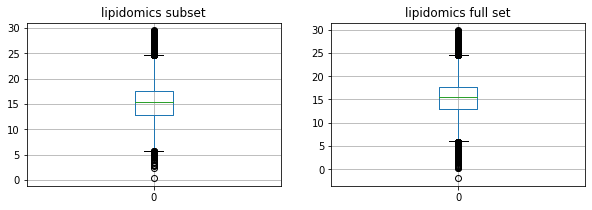

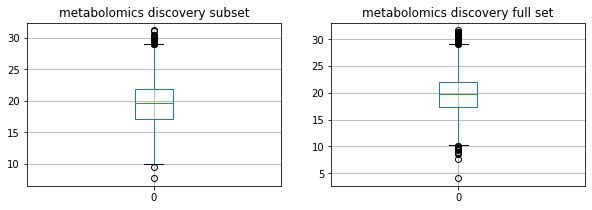

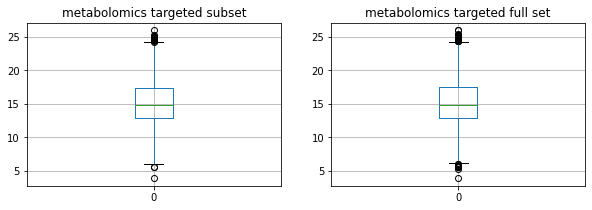

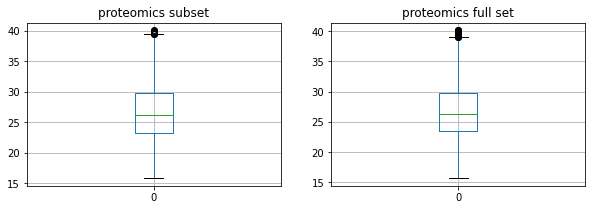

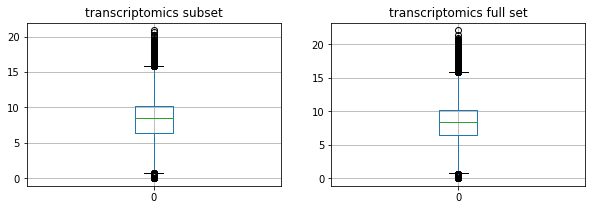

[None, None, None, None, None]

In [17]:
# check that the distribution of data in all covid cases is similar to the subset
def check_dist(data, meta):
    f = plt.figure(figsize=(10,3))
    ax1 = f.add_subplot(121)
    ax1.set_title(meta + " subset")
    ax2 = f.add_subplot(122)
    ax2.set_title(meta + " full set")
    pd.DataFrame(data[75:100].values.flatten()).boxplot(ax=ax1)
    pd.DataFrame(data[:100].values.flatten()).boxplot(ax=ax2)
    plt.show()

meta = [
    "lipidomics",
    "metabolomics discovery",
    "metabolomics targeted",
    "proteomics",
    "transcriptomics",
]
   
[check_dist(x, y) for x, y in list(zip(data_final, meta))]

## Feature selection
To improve run time, feature selection was performed for `transcriptomics data`. This is compared with the full dataset to compare performance.


Features were selected by performing a t test on the data after checking assumptions of independence, distributions and variance. Because of the absence of raw patient data, the t test was performed on normalised abundance measures and did not go through a conventional differential expression pipeline with `edgeR` and `limma`. We note that the purpose of this step is to lower the feature count and not to use these results in downstream analysis.

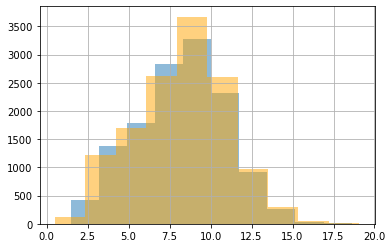

/Users/tche0054/miniconda3/envs/mixomics/lib/python3.8/site-packages/scipy/stats/morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


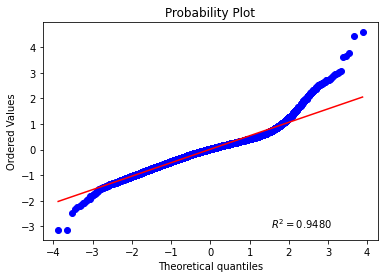

In [18]:
dge_path_covid = "../../data/MSV000085703/data_transcriptomics_dge_covid.tsv"
dge_path_covid_balanced = "../../data/MSV000085703/balanced/data_transcriptomics_dge_covid.tsv"

# we want to reduce features in transcriptomics data only
df = classes_final[4].merge(data_final[4], left_index=True, right_index=True)
df = df.set_index("covid_state")

# perform a welch t test for covid vs noncovid
ttest = stats.ttest_ind(df.loc["Covid"], df.loc["NonCovid"], equal_var=False)
mean_covid = df.loc["Covid"].mean()
mean_noncovid = df.loc["NonCovid"].mean()

# get bh adjusted p values
ttest = pd.DataFrame(multipletests(ttest[1], method="fdr_bh")[1])
ttest.index = df.columns
dgelist = ttest[ttest < 0.05].dropna().index

# independent (no patients are represented in more than 1 sample group)

# variances (similar but not identical)
stats.levene(mean_covid, mean_noncovid, center="mean")

# normal distribution 
df.loc["Covid"].mean().hist(alpha=0.5)
df.loc["NonCovid"].mean().hist(alpha=0.5, color="orange")
plt.show()

sampling_difference = mean_covid - mean_noncovid
stats.shapiro(sampling_difference)
stats.probplot(sampling_difference, plot=plt, rvalue= True)
plt.show()

# subset features and extract (from data imputed separately)
imputed = "../../data/MSV000085703/data_transcriptomics_imputed.tsv"
imputed = pd.read_csv(imputed, sep="\t")

# R formatting forces . in place of -
dgelist = [x.replace("-", ".") for x in dgelist]
imputed[dgelist].to_csv(dge_path_covid, sep="\t")
imputed[dgelist][75:].to_csv(dge_path_covid_balanced, sep="\t")

## Comparison within COVID-19 patients

The `HFD-45` metric created by the authors measures the days a patient is in hospital. The authors use this to classify patients by disease severity.

In [19]:
# transcriptomics covid vs noncovid
dge_path_hfd45 = "../../data/MSV000085703/hfd45/data_transcriptomics_dge_hfd45.tsv"

def extract_hfd45(outpath, data):
    data = data[:100]
    data.to_csv(outpath, sep="\t")
    return data

hfd45_paths = [
    "../../data/MSV000085703/hfd45/data_lipidomics.tsv",
    "../../data/MSV000085703/hfd45/data_metabolomicsdiscovery.tsv",
    "../../data/MSV000085703/hfd45/data_metabolomicstargeted.tsv",
    "../../data/MSV000085703/hfd45/data_proteomics.tsv",
    "../../data/MSV000085703/hfd45/data_transcriptomics.tsv",
]

# transcriptomics hfd45 spectrum
patient_info = patient_metadata.set_index("Albany_sampleID")
patient_info = classes_final[4].merge(patient_info, left_index=True, right_index=True)
patient_info = patient_info[["covid_state", "Hospital_free_days_45"]]
patient_info = patient_info[patient_info["covid_state"] == "Covid"].drop("covid_state", axis=1)

# assign severity score based on median value (26) reported by authors
patient_info[patient_info["Hospital_free_days_45"] <= 26] = 1
patient_info[patient_info["Hospital_free_days_45"] > 26] = 0
patient_info[patient_info["Hospital_free_days_45"] == 1] = "More severe"
patient_info[patient_info["Hospital_free_days_45"] == 0] = "Less severe"
patient_info.to_csv("../../data/MSV000085703/hfd45/classes_diablo.tsv", sep="\t")

# subset data accordingly (take only the 100 covid patients)
covid_only = patient_info.index
hfd45_data = [extract_hfd45(x, y) for x, y in list(zip(hfd45_paths, data_final))]

# subset features and extract (from data imputed separately)
imputed = "../../data/MSV000085703/data_transcriptomics_imputed.tsv"
imputed = pd.read_csv(imputed, sep="\t")

# R formatting forces . in place of -
dgelist = [x.replace("-", ".") for x in dgelist]
imputed[dgelist][:100].to_csv(dge_path_hfd45, sep="\t")
imputed[:100].to_csv("../../data/MSV000085703/hfd45/data_transcriptomics.tsv", sep="\t")


## Combine metabolomics data

The authors combined both sets of `discovery` and `targeted` metabolomics data. We originally separated them to investigate the possibility that the individual blocks of omics data would be informative during integration.

In [20]:
m_covid = "../../data/MSV000085703/data_metabolomics.tsv"
m_hfd45 = "../../data/MSV000085703/hfd45/data_metabolomics.tsv"
m_balanced = "../../data/MSV000085703/balanced/data_metabolomics.tsv"

metabolomics = data_final[1].merge(data_final[2], left_index=True, right_index=True)
metabolomics.to_csv(m_covid, sep="\t")
metabolomics[:100].to_csv(m_hfd45, sep="\t")
metabolomics[75:].to_csv(m_balanced, sep="\t")